In [ ]:
!pip install albumentations==0.4.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from PIL import Image
import os
import sklearn
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
from torchsummary import summary

In [ ]:
class HippocampusDataset(Dataset):
  def __init__(self, image_dir, mask_dir, transform=None):
    self.image_dir = image_dir
    self.mask_dir = mask_dir
    self.transform = transform
    self.images = os.listdir(image_dir)

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    img_path = os.path.join(self.image_dir, self.images[index])
    mask_path = os.path.join(self.mask_dir, self.images[index])
    image = np.array(Image.open(img_path).convert("RGB"),dtype=np.float32)
    # print((h,w,c))
    # image = np.array([[[[image[i][j][k] for j in range(0,w)] for i in range (0,h)] for k in range(0,c)]])
    mask = np.array(Image.open(mask_path),dtype=np.float32)
    # mask[mask==255.0]=1.0
    # print(mask.shape)

    if self.transform is not None:
      augmentations = self.transform(image=image, mask=mask)
      image=augmentations["image"]
      mask=augmentations["mask"]
    # h,w,c = np.array(image).shape
    # print(h,w,c)
    # image = np.array([[[[image[i][j][k] for j in range(0,w)] for i in range (0,h)] for k in range(0,c)]])
    # mask=np.array(mask.convert('L'),dtype=np.float32)
    # print(np.unique(mask),mask.shape)

    return image, mask

In [ ]:
#Hyperparameters
lr = 1e-4
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 8
epochs = 5
img_height = 512
img_width = 512
train_img_dir = "./train"
train_mask_dir = "./train_mask"
val_img_dir = "./val"
val_mask_dir = "./val_mask"
load_model = False

In [ ]:
class conv_block(nn.Module):
  def __init__(self, inp, out):
    super().__init__()
    self.conv1 = nn.Conv2d(inp, out, kernel_size=3, padding=1).to(device)
    self.bn1 = nn.BatchNorm2d(out).to(device)
    self.conv2 = nn.Conv2d(out, out, kernel_size=3, padding=1).to(device)
    self.bn2 = nn.BatchNorm2d(out).to(device)
    self.relu = nn.ReLU()

  def forward(self, input):
    x = self.conv1(input)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)
    return x

class encoder(nn.Module):
  def __init__(self,inp,out):
    super().__init__()
    self.conv = conv_block(inp,out).to(device)
    self.pool = nn.MaxPool2d(2,2).to(device)

  def forward(self,inp):
    x = self.conv(inp)
    p = self.pool(x)
    return [x,p]

class decoder(nn.Module):
  def __init__(self,inp,out,size):
    super().__init__()
    self.up = nn.ConvTranspose2d(inp,out,kernel_size=2,stride=2,padding=0).to(device)
    self.conv = conv_block(size,out).to(device)

  def forward(self,inp,skip):
    x = self.up(inp)
    skip.insert(0,x)
    x = torch.cat(skip, axis=1)
    x = self.conv(x)
    return x

class unetplusplus(nn.Module):
  def __init__(self,l):
    super().__init__()
    n = len(l)-3
    self.e = []
    self.d = []
    for i in range(0,n):
      self.e.append(encoder(l[i],l[i+1]))
      self.d.append([])
      for j in range(0,n-i):
        self.d[i].append(decoder(l[i+2],l[i+1],(j+2)*l[i+1]))
    self.b = conv_block(l[n],l[n+1]).to(device)
    self.out = nn.Conv2d(l[1],l[n+2],kernel_size=1,padding=0).to(device)

  def forward(self,inp):
    n = len(self.e)
    y = []
    for i in range(0,n):
      y.append([self.e[i](inp if i==0 else y[i-1][0][1])])
    y.append([self.b(y[n-1][0][1])])
    for i in range(0,n-1):
      y[i].append(self.d[i][0](y[i+1][0][0],[y[i][0][0]]))
    y[n-1].append(self.d[n-1][0](y[n][0],[y[n-1][0][0]]))
    for j in range(1,n+1):
      for i in range(1,n+1-j):
        y[i-1].append(self.d[i-1][j-1](y[i][j],[y[i-1][k][0] if k==0 else y[i-1][k] for k in range(0,j)]))
    out = self.out(y[0][n])
    return out

# if __name__ == "__main__":
#   h = 256
#   w = 512
#   c = 2
#   input = torch.randn((1,3,h,w)).to(device)
#   print(input.shape)
#   model = unetplusplus([3,64,128,512,1])
#   y = model(input)
#   print(y.shape)
#   #summary(model, input_size=(3, 52, 36))

In [ ]:
input = torch.randn((16,3,36,52))
input = input.to(device)
model_test = unetplusplus([3,64,128,256,1])
model_test = model_test.to(device)
from torchinfo import summary
summary(model_test,input_data=input)

Layer (type:depth-idx)                   Output Shape              Param #
unetplusplus                             [16, 1, 36, 52]           --
├─conv_block: 1-1                        [16, 256, 9, 13]          --
│    └─Conv2d: 2-1                       [16, 256, 9, 13]          295,168
│    └─BatchNorm2d: 2-2                  [16, 256, 9, 13]          512
│    └─ReLU: 2-3                         [16, 256, 9, 13]          --
│    └─Conv2d: 2-4                       [16, 256, 9, 13]          590,080
│    └─BatchNorm2d: 2-5                  [16, 256, 9, 13]          512
│    └─ReLU: 2-6                         [16, 256, 9, 13]          --
├─Conv2d: 1-2                            [16, 1, 36, 52]           65
Total params: 886,337
Trainable params: 886,337
Non-trainable params: 0
Total mult-adds (G): 1.66
Input size (MB): 0.36
Forward/backward pass size (MB): 15.58
Params size (MB): 3.55
Estimated Total Size (MB): 19.48

In [ ]:
def get_loaders(train_img_dir,
      train_mask_dir,
      val_img_dir,
      val_mask_dir,
      batch_size,
      train_transform,
      val_transform):
  train_dataset = HippocampusDataset(
      image_dir=train_img_dir,
      mask_dir=train_mask_dir,
      transform=train_transform,
  )
  # print(train_dataset)
  train_loader = DataLoader(
      train_dataset,
      batch_size=batch_size,
      shuffle=True,
  )

  validation_dataset = HippocampusDataset(
      image_dir=val_img_dir,
      mask_dir=val_mask_dir,
      transform=val_transform,
  )

  validation_loader = DataLoader(
      validation_dataset,
      batch_size=batch_size,
      shuffle=False,
  )

  return train_loader, validation_loader

In [ ]:
def check_accuracy(loader, model, device="cuda"):
  print("accuracy")
  num_correct = 0
  num_pixels = 0
  dice_score = 0
  model.eval()

  with torch.no_grad():
    for x, y in loader:
      x = x.to(device)
      y = y.to(device).unsqueeze(1)
      preds = torch.sigmoid(model(x))
      preds = (preds>0.5).float()
      num_correct += (preds==y).sum()
      num_pixels += torch.numel(preds)
      dice_score += (2*(preds*y).sum())/((preds+y).sum() + 1e-8)

  print(f"{num_correct}/{num_pixels} with accuracy {num_correct/num_pixels*100:.2f}")
  print(f"Dice Score: {dice_score/len(loader)}")

  model.train()


def save_predicted_images(loader, model, folder="saved_images/", device=device):
  model.eval()
  for idx, (x,y) in enumerate(loader):
    x = x.to(device)
    with torch.no_grad():
      preds = torch.sigmoid(model(x))
      # preds = (preds>0.5).float()
      preds *= 255.0
    torchvision.utils.save_image(preds, f"{folder}/pred_{idx}.png")
    torchvision.utils.save_image(y.unsqueeze(1), f"{folder}/actual_{idx}.png")

  model.train()



In [ ]:
def train(loader, model, optimizer, loss_fn, scaler):
  loop = tqdm(loader)
  for batch_idx, (data,targets) in enumerate(loop):
    data = data.to(device=device)
    # data = np.array([[[[data[i][j][k] for j in range(0,w)] for i in range (0,h)] for k in range(0,c)]])
    targets = targets.float().unsqueeze(1).to(device=device)
    # print(targets.shape)
    # print(np.unique(targets.cpu()))

    #forward
    with torch.cuda.amp.autocast():
      # print(data.shape)
      predictions = model(data)
      # print(predictions.shape)
      # img_mask_predictions = predictions.detach().numpy()[0]
      # print(img_mask_predictions.shape)
      # print(targets.shape)
      # img_mask_predictions = np.array([[img_mask_predictions[0][i][j] for j in range(0,w)] for i in range(0,h)])
      loss = loss_fn(0.5+0.5*predictions,targets)

    #backward
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    #update tqdm loop
    loop.set_postfix(loss=loss.item())

    #return


In [ ]:
def save_checkpoint(state, filename="unetplusplus_checkpoint.tar"):
  print("Saving checkpoint --->")
  torch.save(state,filename)

def load_checkpoint(checkpoint, model):
  print("Loading checkpoint --->")
  model.load_state_dict(checkpoint["state_dict"])

In [ ]:
model = unetplusplus([3,64,128,256,1]).to(device)
def main():
  train_transform = A.Compose(
      [
            # A.Resize(height=img_height,width=img_width),
            A.Rotate(limit= 10, p=0.2),
#             A.Sharpen(),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Normalize(
                mean=[0.0,0.0,0.0],
                std=[1.0,1.0,1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2()
      ]
  )

  val_transform = A.Compose(
      [
            # A.Resize(height=img_height,width=img_width),
            # A.Rotate(limit=10),
            # A.HorizontalFlip(p=0.5),
            # A.VerticalFLip(p=0.5),
            A.Normalize(
                mean=[0.0,0.0,0.0],
                std=[1.0,1.0,1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2()
      ]
  )

#   model = unetplusplus([3,128,256,512,1]).to(device)
  loss_fn = nn.BCEWithLogitsLoss()
  optimizer = optim.Adam(model.parameters(), lr=lr)
  scaler = torch.cuda.amp.GradScaler()

  train_loader, val_loader = get_loaders(
      train_img_dir,
      train_mask_dir,
      val_img_dir,
      val_mask_dir,
      batch_size,
      train_transform,
      val_transform,
  )
  # for batch_idx, (data,targets) in enumerate(train_loader):
  #   print(data.shape)
  #   print(targets.shape)

  if load_model:
    load_checkpoint(torch.load("./unetplusplus_checkpoint.tar"), model)

  for epoch in range(epochs):
    #train
    print("Epoch --->", epoch+1)
    train(train_loader, model, optimizer, loss_fn, scaler)

    #save checkpoint
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    save_checkpoint(checkpoint)

    #check accuracy
    check_accuracy(val_loader, model, device=device)

    #save images
    save_predicted_images(val_loader, model, folder="./saveimg/")


if __name__=="__main__":
  main()


Epoch ---> 1


  0%|                                                                                         | 0/1766 [00:02<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 256.00 MiB (GPU 0; 4.00 GiB total capacity; 3.28 GiB already allocated; 0 bytes free; 3.46 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
import cv2
image = cv2.imread('./sample.png')
image = cv2.resize(image, (52, 36))
h, w, c = np.array(image).shape
arr = np.array([ [[[image[i][j][k] for j in range(0,w)] for i in range (0,h)] for k in range(0,c)] ])
print(arr.shape)



(1, 3, 36, 52)


In [ ]:
model.eval()
out = model(torch.tensor((arr.astype(np.float32))/255.0).to(device))

[[-8.96107337e+17 -1.50893801e+18 -1.39053806e+18 ... -1.05260069e+18
  -1.44394175e+18 -1.15123657e+18]
 [-1.19142173e+18 -1.26354282e+18 -9.48723916e+17 ... -8.16557121e+17
  -1.45416460e+18 -8.90311192e+17]
 [-1.48984183e+18 -1.54249785e+18 -1.23488446e+18 ... -9.18387153e+17
  -1.23593257e+18 -1.04108021e+18]
 ...
 [-1.22003583e+18 -1.57700740e+18 -1.25460956e+18 ... -1.43514030e+18
  -1.46538292e+18 -1.40554612e+18]
 [-1.71726220e+18 -8.15413491e+17 -1.16914975e+18 ... -1.27446166e+18
  -1.13188015e+18 -1.03767131e+18]
 [-1.08604124e+18 -1.09595464e+18 -1.19795778e+18 ... -8.71117774e+17
  -1.10950894e+18 -9.08130222e+17]]
[[-4.60172657e+17 -1.07300336e+18 -9.54603417e+17 ... -6.16666044e+17
  -1.00800711e+18 -7.15301858e+17]
 [-7.55487084e+17 -8.27608175e+17 -5.12789237e+17 ... -3.80622441e+17
  -1.01822996e+18 -4.54376513e+17]
 [-1.05390718e+18 -1.10656321e+18 -7.98949816e+17 ... -4.82452474e+17
  -7.99997926e+17 -6.05145499e+17]
 ...
 [-7.84101187e+17 -1.14107275e+18 -8.1867491

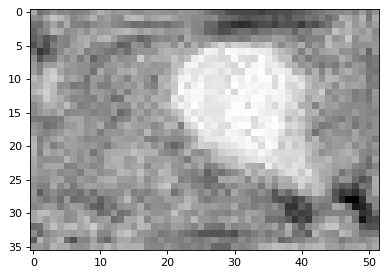

In [ ]:
import matplotlib.pyplot as plt
out = out*255
out = out.to('cpu')
img_mask = out.detach().numpy()[0]
a = np.array([[img_mask[0][i][j] for j in range(0,w)] for i in range(0,h)])
print(a)
a = np.array([[np.max(a)+j if j<0 else j for j in i] for i in a])
print(a)
plt.figure(dpi=80)
plt.imshow(a, cmap= 'gray')